In [1]:
from matplotlib.lines import Line2D
import numba
from numba import jit

In [6]:
model_loc = '/eos/uscms/store/user/srosenzw/weaver/models/exp_sixb_official/feynnet_ranker_6b/20230731_7d266883bbfb88fe4e226783a7d1c9db_ranger_lr0.0047_batch2000_withbkg/predict_output/2018'
sample_loc = '/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL'

maxbtag_file = f'{sample_loc}/maxbtag/NMSSM/NMSSM_XYH_YToHH_6b_MX_700_MY_400_2M/ntuple.root'
# assert 'btagsf' in maxbtag_file
maxbtag_feyn = f'{model_loc}/maxbtag/NMSSM_XYH_YToHH_6b_MX_700_MY_400_2M.root'
# assert 'sf_' in maxbtag_feyn
maxbtag = SixB(maxbtag_file, feyn=maxbtag_feyn)

tree_file = f'{sample_loc}/maxbtag_4b/Official_NMSSM/NMSSM_XToYHTo6B_MX-700_MY-400_TuneCP5_13TeV-madgraph-pythia8/ntuple.root'
assert 'maxbtag_4b' in tree_file
tree_feyn = f'{model_loc}/NMSSM_XToYHTo6B_MX-700_MY-400_TuneCP5_13TeV-madgraph-pythia8.root'
tree = SixB(tree_file, feyn=tree_feyn)

ntuple: /eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag/NMSSM/NMSSM_XYH_YToHH_6b_MX_700_MY_400_2M/ntuple.root
model: /eos/uscms/store/user/srosenzw/weaver/models/exp_sixb_official/feynnet_ranker_6b/20230731_7d266883bbfb88fe4e226783a7d1c9db_ranger_lr0.0047_batch2000_withbkg/predict_output/2018/maxbtag/NMSSM_XYH_YToHH_6b_MX_700_MY_400_2M.root
ntuple: /eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag_4b/Official_NMSSM/NMSSM_XToYHTo6B_MX-700_MY-400_TuneCP5_13TeV-madgraph-pythia8/ntuple.root
model: /eos/uscms/store/user/srosenzw/weaver/models/exp_sixb_official/feynnet_ranker_6b/20230731_7d266883bbfb88fe4e226783a7d1c9db_ranger_lr0.0047_batch2000_withbkg/predict_output/2018/NMSSM_XToYHTo6B_MX-700_MY-400_TuneCP5_13TeV-madgraph-pythia8.root


In [7]:
bsf_names = [key for key in maxbtag.keys() if key.startswith('bSFshape')]

In [8]:
bsf_names

['bSFshape_central',
 'bSFshape_up_jes',
 'bSFshape_down_jes',
 'bSFshape_up_jesAbsolute',
 'bSFshape_down_jesAbsolute',
 'bSFshape_up_jesBBEC1',
 'bSFshape_down_jesBBEC1',
 'bSFshape_up_jesEC2',
 'bSFshape_down_jesEC2',
 'bSFshape_up_jesFlavorQCD',
 'bSFshape_down_jesFlavorQCD',
 'bSFshape_up_jesHF',
 'bSFshape_down_jesHF',
 'bSFshape_up_jesRelativeBal',
 'bSFshape_down_jesRelativeBal',
 'bSFshape_up_jesRelativeSample',
 'bSFshape_down_jesRelativeSample',
 'bSFshape_up_hf',
 'bSFshape_down_hf',
 'bSFshape_up_lf',
 'bSFshape_down_lf',
 'bSFshape_up_lfstats1',
 'bSFshape_down_lfstats1',
 'bSFshape_up_lfstats2',
 'bSFshape_down_lfstats2',
 'bSFshape_up_hfstats1',
 'bSFshape_down_hfstats1',
 'bSFshape_up_hfstats2',
 'bSFshape_down_hfstats2']

In [29]:
bsf_central = maxbtag.get('bSFshape_central', library='np')
maxbtag.tree['bSFshape_central'].array(), bsf_central

(<Array [1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1] type='1061136 * float32'>,
 array([1., 1., 1., ..., 1., 1., 1.], dtype=float32))

In [24]:
n_bins = np.arange(ak.min(maxbtag.n_jet), ak.max(maxbtag.n_jet) + 2)
x_n = (n_bins[1:] + n_bins[:-1]) / 2

In [25]:
maxbtag_scale = np.repeat(maxbtag.scale, len(maxbtag.n_jet))

### 1D correction in jet multiplicity

Text(1, 0, 'Jet Multiplicity')

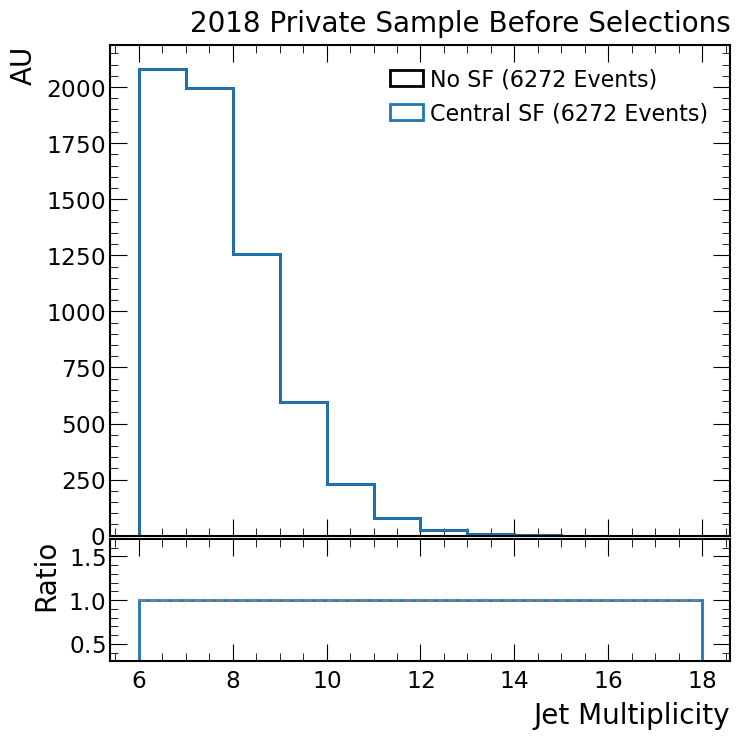

In [22]:
n_before, e_b = np.histogram(maxbtag.n_jet.to_numpy(), bins=n_bins, weights=maxbtag_scale)
n_after, e_a  = np.histogram(maxbtag.n_jet.to_numpy(), bins=n_bins, weights=bsf_central*maxbtag_scale)

total_before = int(len(maxbtag.n_jet) * maxbtag.scale)
total_after  = int(bsf_central.sum() * maxbtag.scale)

fig, axs = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [4,1]}, figsize=(8,8), sharex=True)
plt.subplots_adjust(hspace=0.01)

ax = axs[0]
ax.set_title('2018 Private Sample Before Selections')
n_b = Hist(x_n, weights=n_before, bins=n_bins, ax=ax, label=f'No SF ({total_before} Events)', color='k')
n_a = Hist(x_n, weights=n_after, bins=n_bins, ax=ax, label=f'Central SF ({total_after} Events)', color='C0')
ax.set_ylabel('AU')

ax = axs[1]
central_1d_ratio = np.nan_to_num(n_b/n_a, nan=1.0)
n = Hist(x_n, weights=central_1d_ratio, bins=n_bins, ax=ax, color='C0')
ax.plot([n_bins.min(), n_bins.max()], [1, 1], '--', color='grey')
ax.set_ylabel('Ratio')
ax.set_ylim(0.3,1.7)
ax.set_xlabel('Jet Multiplicity')

# fig.savefig('plots/systematics/btag_reshaping_sfs/jet_mult.pdf')

In [67]:
ratio_dict = {int(e):n for e,n in zip(n_bins[:-1], central_1d_ratio)}
print(ratio_dict)

get_ratio = lambda x : ratio_dict[x]
v_ratio = np.vectorize(get_ratio)

bsf_central_1d = v_ratio(maxbtag.n_jet.to_numpy()) * bsf_central
print(bsf_central_1d)

{6: 1.0523819889911643, 7: 1.0407451011402458, 8: 1.0275378560570596, 9: 1.0085806355366314, 10: 0.9882910129816392, 11: 0.9655276469570246, 12: 0.9491447971301967, 13: 0.9397614719560133, 14: 0.8796787950777801, 15: 0.9415719956150773, 16: 0.9129294828487661, 17: 1.0510190939357809, 18: 0.4943583701349415}
[0.94491298 0.53719328 2.51880198 ... 0.73418417 0.93990079 0.9381999 ]


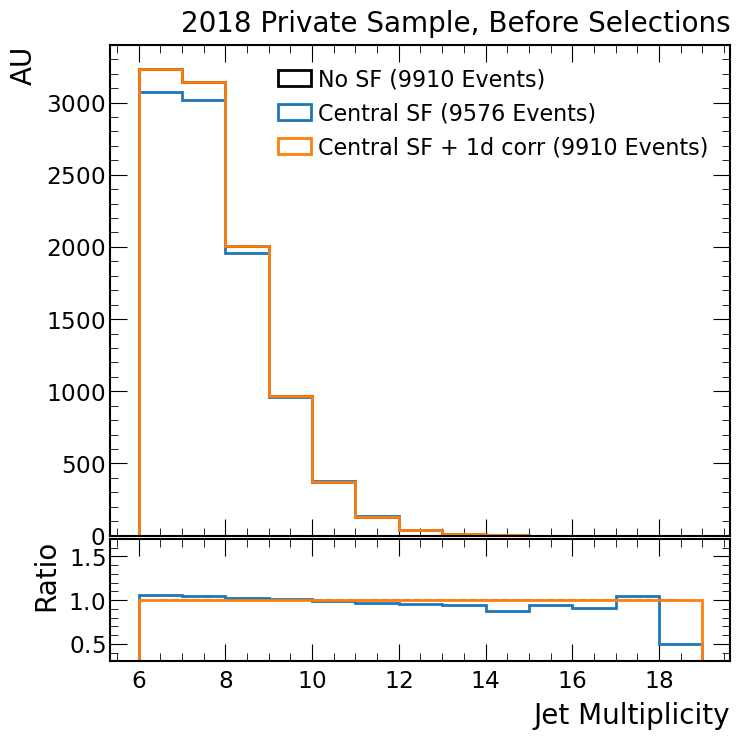

In [62]:
n_bef_corr, e = np.histogram(maxbtag.n_jet.to_numpy(), bins=n_bins, weights=maxbtag_scale)
n_aft_corr, e  = np.histogram(maxbtag.n_jet.to_numpy(), bins=n_bins, weights=bsf_central_1d*maxbtag_scale)

total_bef_corr = int(len(maxbtag.n_jet) * maxbtag.scale)
total_aft_corr  = int(bsf_central_1d.sum() * maxbtag.scale)

fig, axs = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios':[4,1]}, sharex=True, figsize=(8,8))
plt.subplots_adjust(hspace=0.01)

ax = axs[0]
n_b_corr = Hist(x_n, weights=n_bef_corr, bins=n_bins, ax=ax, label=f'No SF ({total_bef_corr} Events)', color='k')
n_a = Hist(x_n, weights=n_after, bins=n_bins, ax=ax, label=f'Central SF ({total_after} Events)', color='C0')
n_a_corr = Hist(x_n, weights=n_aft_corr, bins=n_bins, ax=ax, label=f'Central SF + 1d corr ({total_aft_corr} Events)', color='C1')
ax.set_title('2018 Private Sample, Before Selections')
ax.set_ylabel('AU')

ratio_1d_corr = n_b_corr / n_a_corr
ax = axs[1]
ax.plot(x_n, np.ones_like(x_n), '--', color='gray')
n = Hist(x_n, weights=central_1d_ratio, bins=n_bins, ax=ax, color='C0')
n = Hist(x_n, weights=ratio_1d_corr, bins=n_bins, color='C1', ax=ax)
ax.set_ylim(0.3,1.7)
ax.set_xlabel('Jet Multiplicity')
ax.set_ylabel('Ratio')

fig.savefig('plots/systematics/btag_reshaping_sfs/jet_mult_ratio_check.pdf')

In [121]:
50*(round(247.5/50) - 1)

200

In [17]:
ht = maxbtag.get('PFHT')
print(ak.min(ht), ak.max(ht))
HT_bins = np.arange(200, 6450, 25)
x_ht = (HT_bins[1:] + HT_bins[:-1]) / 2

330.03125 6351.75


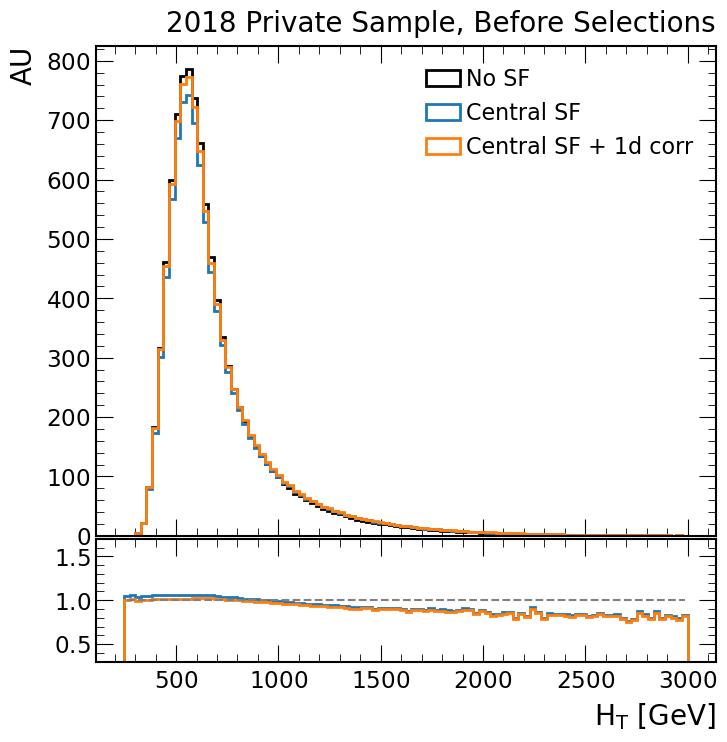

In [93]:
ht_bins = np.linspace(245, 3000, 101)
x_ht = (ht_bins[1:] + ht_bins[:-1]) / 2
fig, axs = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios':[4,1]}, sharex=True, figsize=(8,8))
plt.subplots_adjust(hspace=0.01)

ax = axs[0]
ax.set_title('2018 Private Sample, Before Selections')
n1 = Hist(ht, bins=ht_bins, ax=ax, weights=maxbtag.scale, label='No SF', color='k')
n2 = Hist(ht, bins=ht_bins, ax=ax, weights=maxbtag.scale*bsf_central, label='Central SF', color='C0')
n3 = Hist(ht, bins=ht_bins, ax=ax, weights=maxbtag.scale*bsf_central_1d, label='Central SF + 1d corr', color='C1')
ratio1 = n1/n2
ratio1 = np.nan_to_num(ratio1, posinf=1.0)
ratio2 = n1/n3
ratio2 = np.nan_to_num(ratio2, posinf=1.0)
ax.set_ylabel('AU')

ax = axs[1]
n = Hist(x_ht, weights=ratio1, bins=ht_bins, ax=ax, color='C0')
n = Hist(x_ht, weights=ratio2, bins=ht_bins, ax=ax, color='C1')
ax.plot(x_ht, np.ones_like(x_ht), '--', color='gray')
ax.set_ylim(0.3,1.7)
ax.set_xlabel(r'$H_T$ [GeV]')

fig.savefig('plots/systematics/btag_reshaping_sfs/ht_1d_ratio.pdf')

HT doesn't quite match

### 2d Correction

In [19]:
def get_2d_ratio(ratio, n, ht):
    i = np.digitize(n, n_bins) - 1
    j = np.digitize(ht, HT_bins) - 1
    if i < 0: i = 0
    if j < 0: j = 0
    return ratio[i,j]

In [20]:
def calculate_ratio(bsf):
    fig, axs = plt.subplots(ncols=2, figsize=(16,6))

    ax = axs[0]
    n1, xe, xy, im = Hist2d(maxbtag.n_jet, ht, bins=[n_bins, HT_bins], ax=ax, weights=maxbtag_scale)
    fig.colorbar(im, ax=ax)

    ax = axs[1]
    n2, xe, xy, im = Hist2d(maxbtag.n_jet, ht, bins=[n_bins, HT_bins], ax=ax, weights=bsf*maxbtag_scale)
    fig.colorbar(im, ax=ax)

    ratio = n1/n2
    ratio = np.nan_to_num(ratio, nan=1.0)
    plt.close()

    return ratio

In [18]:
b4_corrs = {}
for name in bsf_names:
    bsf = maxbtag.get(name, library='np')
    b4_corrs[name] = calculate_ratio(bsf)

def calculate_bsfs(t):
    bsfs_corr = {}
    for name,corr in b4_corrs.items():
        bsfs_corr[name] = b4_corrs[name][np.digitize(t.n_jet.to_numpy(), n_bins) - 1, np.digitize(t.get('PFHT', library='np'), HT_bins) - 1]*t.get(name, library='np')
    return bsfs_corr

bsf_2d_corr = calculate_bsfs(maxbtag)

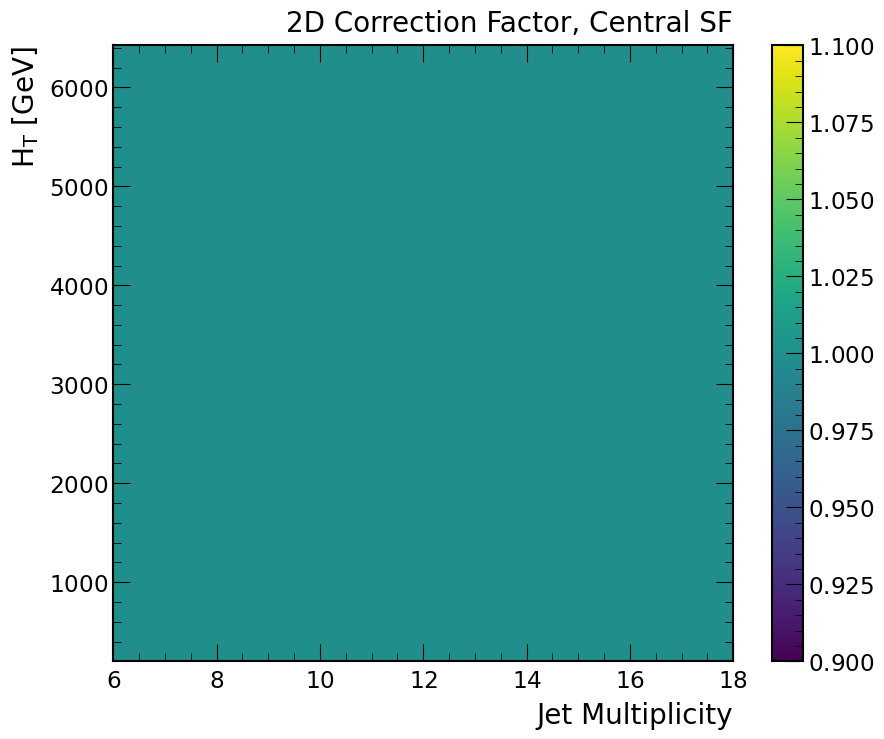

In [21]:
fig, ax = plt.subplots(figsize=(10,8))

n1, xe, ye, im = Hist2d(maxbtag.n_jet, maxbtag.get('PFHT', library='np'), bins=[n_bins, HT_bins], ax=ax, weights=maxbtag_scale)
n2, xe, ye, im = Hist2d(maxbtag.n_jet, maxbtag.get('PFHT', library='np'), bins=[n_bins, HT_bins], ax=ax, weights=maxbtag_scale*bsf_central)
plt.cla()
ratio = np.nan_to_num(n1/n2, nan=1.0)
im = ax.imshow(ratio.T, origin='lower', extent=[n_bins.min(), n_bins.max(), HT_bins.min(), HT_bins.max()], aspect='auto')
fig.colorbar(im, ax=ax)
ax.set_xlabel('Jet Multiplicity')
ax.set_ylabel(r'$H_T$ [GeV]')
ax.set_title('2D Correction Factor, Central SF')

# fig.savefig('plots/systematics/btag_reshaping_sfs/central_2d_ratio.pdf')

In [12]:
tree_bsf_2d = calculate_bsfs(tree)

NameError: name 'calculate_bsfs' is not defined

In [58]:
bsf_2d_corr

{'bSFshape_central': array([0.9657307 , 0.54546532, 2.5431786 , ..., 0.72166046, 0.93789623,
        0.9221961 ]),
 'bSFshape_up_jes': array([0.93846092, 0.59131573, 2.43978484, ..., 0.76232188, 0.86276002,
        0.90869704]),
 'bSFshape_down_jes': array([0.98338948, 0.5076853 , 2.72819478, ..., 0.68192927, 0.99040478,
        0.93348316]),
 'bSFshape_up_hf': array([0.98466321, 0.55426501, 2.4025378 , ..., 0.73942623, 0.97323887,
        0.94249511]),
 'bSFshape_down_hf': array([0.94330189, 0.5351737 , 2.76378633, ..., 0.70644617, 0.90385613,
        0.88522007]),
 'bSFshape_up_lf': array([0.832008  , 0.62211453, 2.23703639, ..., 0.90420418, 0.81813772,
        1.01590223]),
 'bSFshape_down_lf': array([1.06548836, 0.47073   , 2.72539362, ..., 0.55215615, 1.01420405,
        0.85169734]),
 'bSFshape_up_lfstats1': array([0.96487591, 0.53805505, 2.65988214, ..., 0.73974286, 0.91781035,
        0.91987738]),
 'bSFshape_down_lfstats1': array([0.96531803, 0.55283154, 2.42360328, ..., 0.704

In [68]:
bsf_central_2d = bsf_2d_corr['bSFshape_central']

Text(1, 0, 'Leading Jet $p_T$ [GeV]')

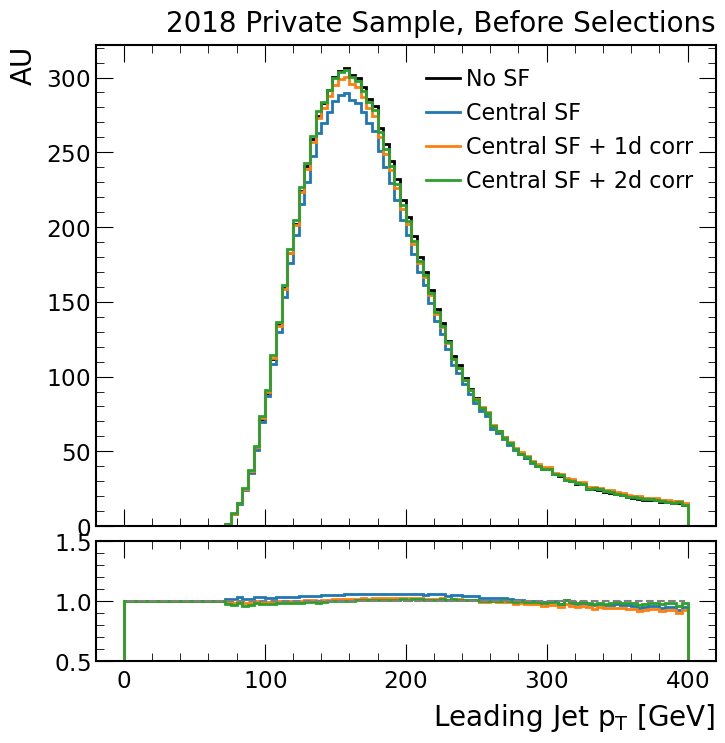

In [72]:
pt_bins = np.linspace(0,400,101)
x_pt = (pt_bins[1:] + pt_bins[:-1]) / 2
fig, axs = plt.subplots(nrows=2, gridspec_kw={'height_ratios':[4,1]}, sharex=True, figsize=(8,8))
plt.subplots_adjust(hspace=0.05)

ax = axs[0]
n_1 = Hist(ak.sort(maxbtag.jet_pt, ascending=False, axis=1)[:,0], bins=pt_bins, ax=ax, weights=maxbtag.scale, color='k')
n_2 = Hist(ak.sort(maxbtag.jet_pt, ascending=False, axis=1)[:,0], bins=pt_bins, ax=ax, weights=maxbtag.scale*bsf_central, color='C0')
n_3 = Hist(ak.sort(maxbtag.jet_pt, ascending=False, axis=1)[:,0], bins=pt_bins, ax=ax, weights=maxbtag.scale*bsf_central_1d, color='C1')
n_4 = Hist(ak.sort(maxbtag.jet_pt, ascending=False, axis=1)[:,0], bins=pt_bins, ax=ax, weights=maxbtag.scale*bsf_central_2d, color='C2')

handle1 = Line2D([0], [0], color='k', lw=2, label='No SF')
handle2 = Line2D([0], [0], color='C0', lw=2, label='Central SF')
handle3 = Line2D([0], [0], color='C1', lw=2, label='Central SF + 1d corr')
handle4 = Line2D([0], [0], color='C2', lw=2, label='Central SF + 2d corr')
ax.legend(handles=[handle1, handle2, handle3, handle4])

ax.set_ylabel('AU')
ax.set_title('2018 Private Sample, Before Selections')

ax = axs[1]
ratio1 = np.nan_to_num(n_1/n_2, nan=1.0)
ratio2 = np.nan_to_num(n_1/n_3, nan=1.0)
ratio3 = np.nan_to_num(n_1/n_4, nan=1.0)
n = Hist(x_pt, weights=ratio1, bins=pt_bins, ax=ax, color='C0')
n = Hist(x_pt, weights=ratio2, bins=pt_bins, ax=ax, color='C1')
n = Hist(x_pt, weights=ratio3, bins=pt_bins, ax=ax, color='C2')
ax.plot(x_pt, np.ones_like(x_pt), '--', color='gray')
ax.set_ylim(0.5,1.5)

ax.set_xlabel(r'Leading Jet $p_T$ [GeV]')
# fig.savefig('plots/systematics/btag_reshaping_sfs/leading_jet_pt.pdf')

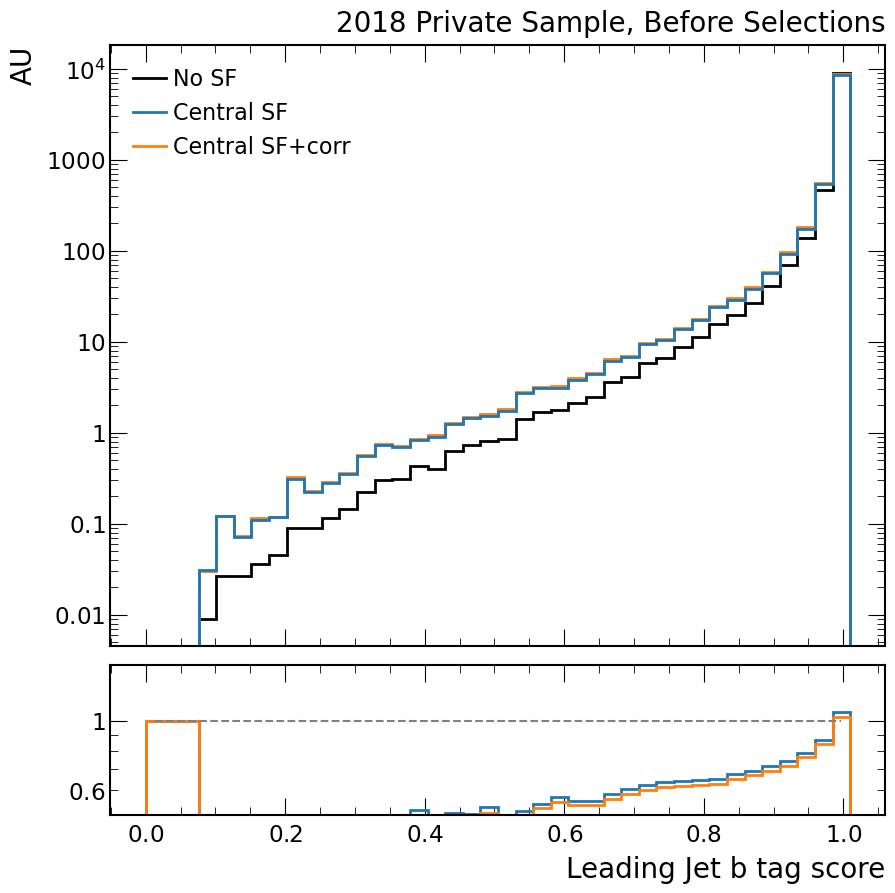

In [73]:
b_bins = np.linspace(0,1.01,41)
x_b = (b_bins[1:] + b_bins[:-1]) / 2

fig, axs = plt.subplots(nrows=2, gridspec_kw={'height_ratios':[4,1]}, sharex=True)
plt.subplots_adjust(hspace=0.05)

ax = axs[0]
n_1 = Hist(maxbtag.jet_btag[:,0], bins=b_bins, ax=ax, weights=maxbtag.scale, color='k')
n_3 = Hist(maxbtag.jet_btag[:,0], bins=b_bins, ax=ax, weights=maxbtag.scale*bsf_central_2d, color='C1')
n_2 = Hist(maxbtag.jet_btag[:,0], bins=b_bins, ax=ax, weights=maxbtag.scale*bsf_central, color='C0')

handle1 = Line2D([0], [0], color='k', lw=2, label='No SF')
handle2 = Line2D([0], [0], color='C0', lw=2, label='Central SF')
handle3 = Line2D([0], [0], color='C1', lw=2, label='Central SF+corr')
ax.legend(handles=[handle1, handle2, handle3])

ax.set_ylabel('AU')
ax.set_title('2018 Private Sample, Before Selections')

ax = axs[1]
ratio1 = n_1 / n_2
ratio1 = np.nan_to_num(ratio1, nan=1.0)
ratio2 = n_1 / n_3
ratio2 = np.nan_to_num(ratio2, nan=1.0)
n = Hist(x_b, weights=ratio1, bins=b_bins, ax=ax, color='C0')
n = Hist(x_b, weights=ratio2, bins=b_bins, ax=ax, color='C1')
ax.plot(x_b, np.ones_like(x_b), '--', color='gray')
ax.set_ylim(0.5,1.5)
ax.set_xlabel('Leading Jet b tag score')

for ax in axs.flatten():
    ax.set_yscale('log')

# fig.savefig('plots/systematics/btag_reshaping_sfs/leading_jet_btag.pdf')

In [76]:
b_bins = np.linspace(0,1.01,101)
x_b = (bins[1:] + bins[:-1]) / 2

9911 9577 9911


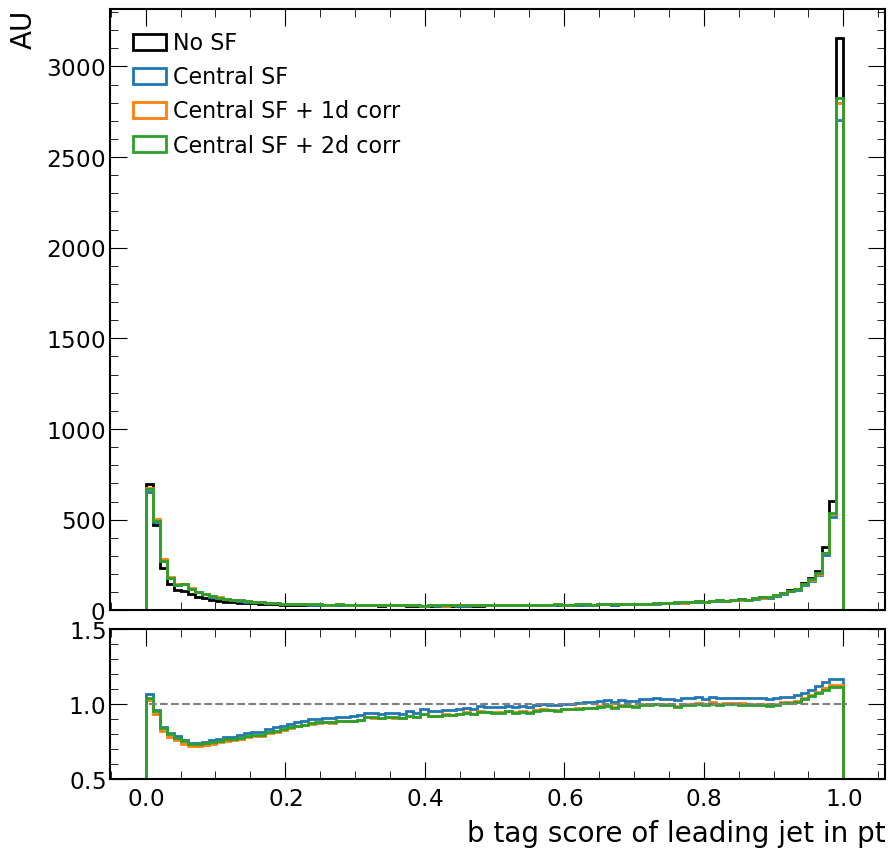

In [77]:
pt_sort_mask = ak.argsort(maxbtag.jet_pt, ascending=False)

fig, axs = plt.subplots(nrows=2, gridspec_kw={'height_ratios':[4,1]}, sharex=True)
plt.subplots_adjust(hspace=0.05)

ax = axs[0]
n1 = Hist(maxbtag.jet_btag[pt_sort_mask][:,0], bins=b_bins, ax=ax, weights=maxbtag.scale, color='k', label='No SF')
n2 = Hist(maxbtag.jet_btag[pt_sort_mask][:,0], bins=b_bins, ax=ax, weights=maxbtag.scale*bsf_central, color='C0', label='Central SF')
n3 = Hist(maxbtag.jet_btag[pt_sort_mask][:,0], bins=b_bins, ax=ax, weights=maxbtag.scale*bsf_central_1d, color='C1', label='Central SF + 1d corr')
n4 = Hist(maxbtag.jet_btag[pt_sort_mask][:,0], bins=b_bins, ax=ax, weights=maxbtag.scale*bsf_central_2d, color='C2', label='Central SF + 2d corr')
ratio1 = np.nan_to_num(n1/n2)
ratio2 = np.nan_to_num(n1/n3)
ratio3 = np.nan_to_num(n1/n4)
ax.set_ylabel('AU')

print(round(maxbtag_scale.sum()), round(maxbtag.scale*bsf_central.sum()), round(maxbtag.scale*bsf_central_2d.sum()))

ax = axs[1]
n = Hist(x_b, weights=ratio1, bins=b_bins, ax=ax, color='C0')
n = Hist(x_b, weights=ratio2, bins=b_bins, ax=ax, color='C1')
n = Hist(x_b, weights=ratio3, bins=b_bins, ax=ax, color='C2')
ax.plot(x_b, np.ones_like(x_b), '--', color='gray')
ax.set_ylim(0.5,1.5)
ax.set_xlabel('b tag score of leading jet in pt')

fig.savefig('plots/systematics/btag_reshaping_sfs/leading_pt_jet_btag_ratio.pdf')

In [51]:
ht_bins = np.linspace(245, 3000, 101)
x_ht = (ht_bins[1:] + ht_bins[:-1]) / 2
for name,bsf in bsf_2d_corr.items():
    fig, axs = plt.subplots(nrows=2, gridspec_kw={'height_ratios':[4,1]}, sharex=True)
    plt.subplots_adjust(hspace=0.05)

    ax = axs[0]
    n1 = Hist(ht, bins=ht_bins, ax=ax, weights=maxbtag.scale, label='No SF', color='k')
    n2 = Hist(ht, bins=ht_bins, ax=ax, weights=maxbtag.scale*bsf, label=name, color='C0')
    ratio = n1/n2
    ratio = np.nan_to_num(ratio, posinf=1.0)
    ax.set_ylabel('AU')

    ax = axs[1]
    n = Hist(x_ht, weights=ratio, bins=ht_bins, ax=ax, color='C0')
    ax.plot(x_ht, np.ones_like(x_ht), '--', color='gray')
    ax.set_ylim(0.5,1.5)
    ax.set_xlabel(r'$H_T$ [GeV]')
    ax.set_ylabel('Ratio')
    fig.savefig(f'plots/systematics/btag_reshaping_sfs/ht_{name}.pdf')
    plt.close()

In [53]:
n_bins = np.arange(6, 16)
x_n = (n_bins[1:] + n_bins[:-1]) / 2
for name,bsf in bsf_2d_corr.items():
    
    fig, axs = plt.subplots(nrows=2, gridspec_kw={'height_ratios':[4,1]}, sharex=True)
    plt.subplots_adjust(hspace=0.05)

    ax = axs[0]
    n1 = Hist(maxbtag.n_jet, bins=n_bins, ax=ax, weights=maxbtag.scale, label='No SF', color='k')
    n2 = Hist(maxbtag.n_jet, bins=n_bins, ax=ax, weights=maxbtag.scale*bsf, label=name, color='C0')
    ratio = n1/n2
    ratio = np.nan_to_num(ratio, posinf=1.0)
    ax.set_ylabel('AU')

    ax = axs[1]
    n = Hist(x_n, weights=ratio, bins=n_bins, ax=ax, color='C0')
    ax.plot(x_n, np.ones_like(x_n), '--', color='gray')
    ax.set_ylim(0.5,1.5)
    ax.set_xlabel('Jet Multiplicity')
    fig.savefig(f'plots/systematics/btag_reshaping_sfs/jet_mult_{name}.pdf')
    plt.close()

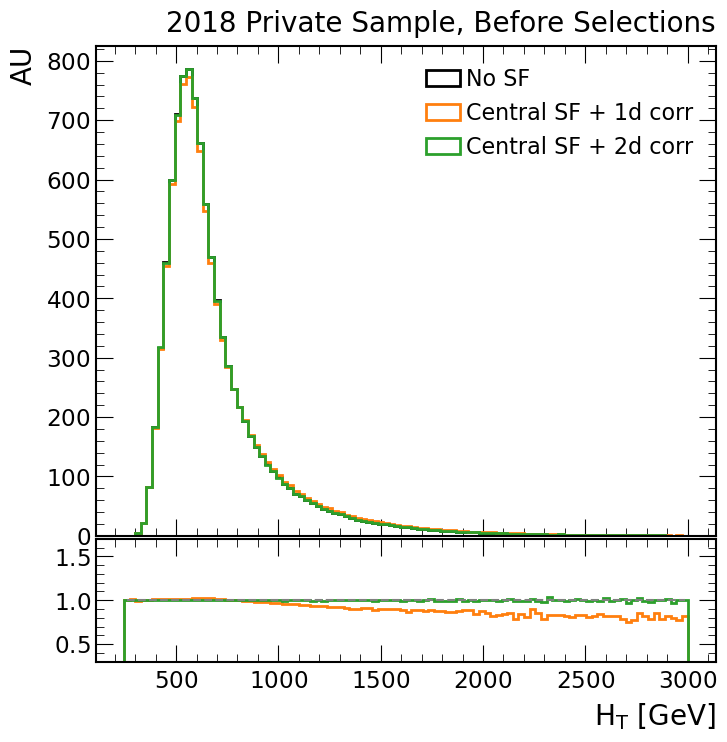

In [100]:
ht_bins = np.linspace(245, 3000, 101)
x_ht = (ht_bins[1:] + ht_bins[:-1]) / 2
fig, axs = plt.subplots(nrows=2, gridspec_kw={'height_ratios':[4,1]}, sharex=True, figsize=(8,8))
plt.subplots_adjust(hspace=0.01)

ax = axs[0]
n1 = Hist(ht, bins=ht_bins, ax=ax, weights=maxbtag.scale, label='No SF', color='k')
n2 = Hist(ht, bins=ht_bins, ax=ax, weights=maxbtag.scale*bsf_central_1d, label='Central SF + 1d corr', color='C1')
n3 = Hist(ht, bins=ht_bins, ax=ax, weights=maxbtag.scale*bsf_central_2d, label='Central SF + 2d corr', color='C2')
ratio1 = np.nan_to_num(n1/n2, posinf=1.0)
ratio2 = np.nan_to_num(n1/n3, posinf=1.0)
ax.set_ylabel('AU')
ax.set_title('2018 Private Sample, Before Selections')

ax = axs[1]
n = Hist(x_ht, weights=ratio1, bins=ht_bins, ax=ax, color='C1')
n = Hist(x_ht, weights=ratio2, bins=ht_bins, ax=ax, color='C2')
ax.plot(x_ht, np.ones_like(x_ht), '--', color='gray')
ax.set_ylim(0.3,1.7)
ax.set_xlabel(r'$H_T$ [GeV]')

fig.savefig('plots/systematics/btag_reshaping_sfs/ht_2d_ratio.pdf')

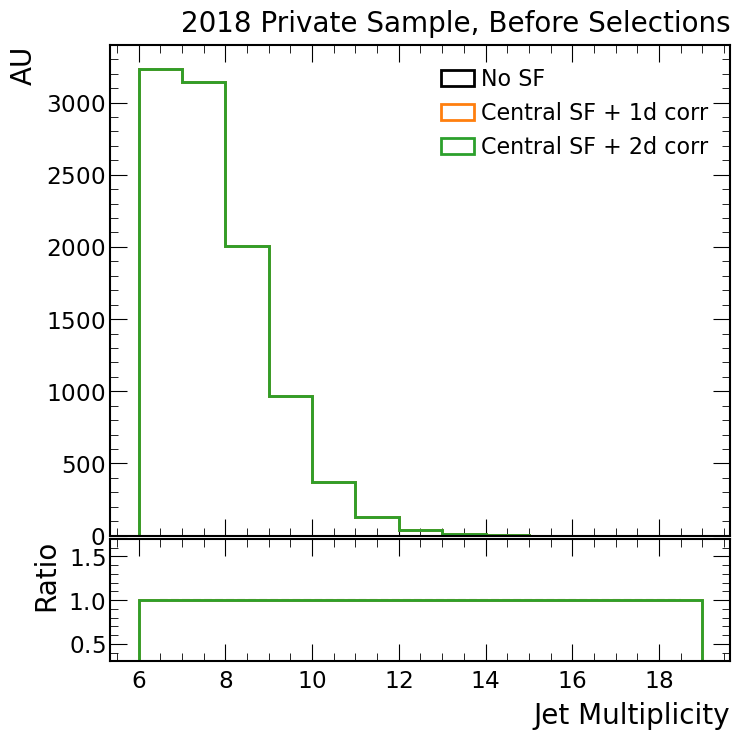

In [101]:
fig, axs = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios':[4,1]}, sharex=True, figsize=(8,8))
plt.subplots_adjust(hspace=0.01)

ax = axs[0]
n1 = Hist(maxbtag.n_jet, bins=n_bins, ax=ax, weights=maxbtag.scale, label='No SF', color='k')
n2 = Hist(maxbtag.n_jet, bins=n_bins, ax=ax, weights=maxbtag.scale*bsf_central_1d, label='Central SF + 1d corr', color='C1')
n3 = Hist(maxbtag.n_jet, bins=n_bins, ax=ax, weights=maxbtag.scale*bsf_central_2d, label='Central SF + 2d corr', color='C2')
ratio1 = np.nan_to_num(n1/n2, posinf=1.0)
ratio2 = np.nan_to_num(n1/n3, posinf=1.0)
ax.set_title('2018 Private Sample, Before Selections')
ax.set_ylabel('AU')

ax = axs[1]
ax.plot(x_n, np.ones_like(x_n), '--', color='gray')
n = Hist(x_n, weights=ratio1, bins=n_bins, ax=ax, color='C1')
n = Hist(x_n, weights=ratio2, bins=n_bins, color='C2', ax=ax)
ax.set_ylim(0.3,1.7)
ax.set_xlabel('Jet Multiplicity')
ax.set_ylabel('Ratio')

fig.savefig('plots/systematics/btag_reshaping_sfs/jet_mult_2d.pdf')

Text(1, 0, '$M(HX)$ [GeV]')

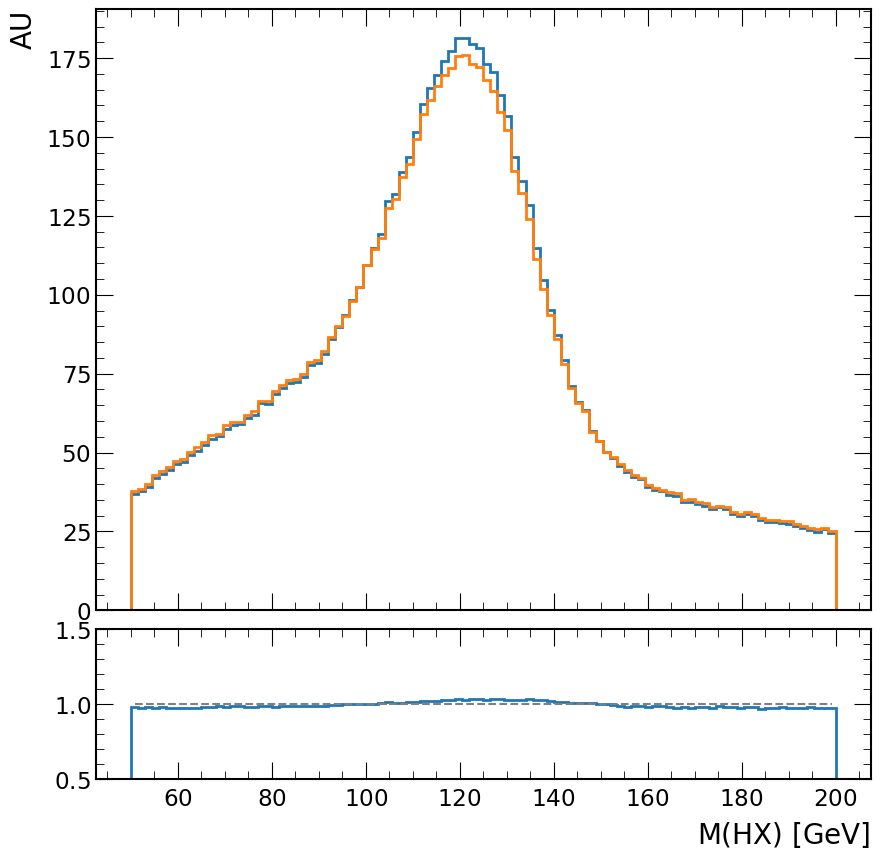

In [391]:
mh_bins = np.linspace(50,200,101)
x_mh = (mh_bins[1:] + mh_bins[:-1]) / 2
fig, axs = plt.subplots(nrows=2, gridspec_kw={'height_ratios':[4,1]}, sharex=True)
plt.subplots_adjust(hspace=0.05)

ax = axs[0]
n1 = Hist(maxbtag.HX.m, bins=mh_bins, ax=ax, weights=maxbtag.scale)
n2 = Hist(maxbtag.HX.m, bins=mh_bins, ax=ax, weights=maxbtag.scale*bsf_2d_corr)
ratio = n1/n2
ratio = np.nan_to_num(ratio)
ax.set_ylabel('AU')

ax = axs[1]
n = Hist(x_mh, weights=ratio, bins=mh_bins, ax=ax)
ax.plot(x_mh, np.ones_like(x_mh), '--', color='gray')
ax.set_ylim(0.5,1.5)
ax.set_xlabel(r'$M(HX)$ [GeV]')

# fig.savefig('plots/systematics/btag_reshaping_sfs/ht_ratio.pdf')

6883.583017276443 6811.313602412517
9910.708907714523 9910.70890758952


Text(1, 0, '$M(H1)$ [GeV]')

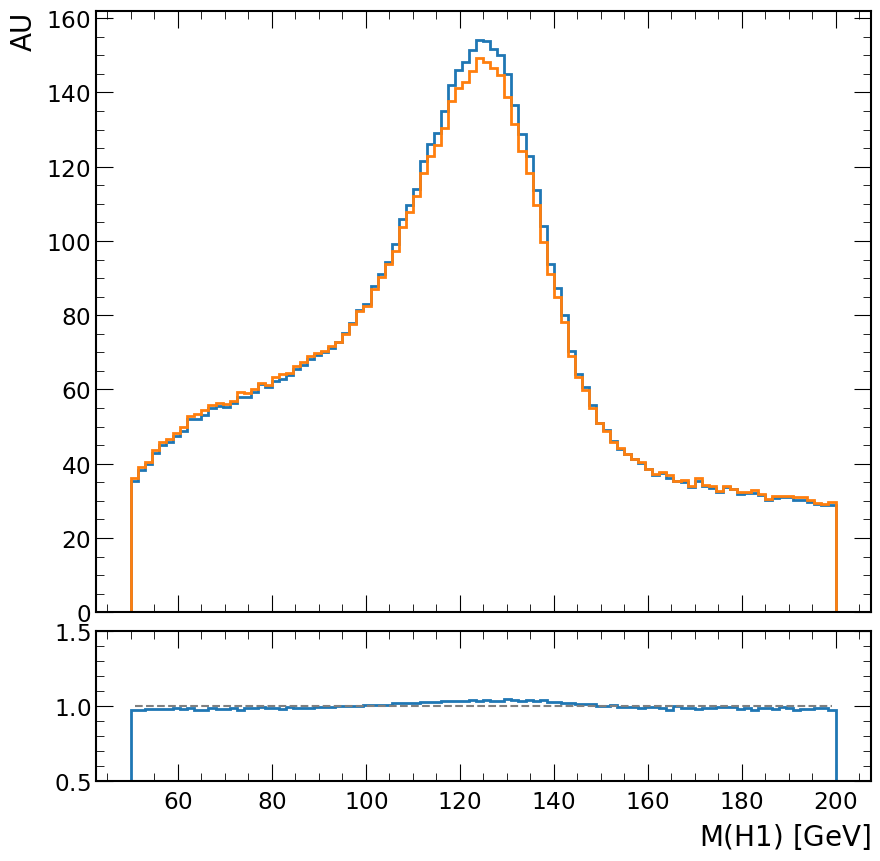

In [89]:
mh_bins = np.linspace(50,200,101)
x_mh = (mh_bins[1:] + mh_bins[:-1]) / 2
fig, axs = plt.subplots(nrows=2, gridspec_kw={'height_ratios':[4,1]}, sharex=True)
plt.subplots_adjust(hspace=0.05)

ax = axs[0]
n1 = Hist(maxbtag.H1.m, bins=mh_bins, ax=ax, weights=maxbtag.scale)
n2 = Hist(maxbtag.H1.m, bins=mh_bins, ax=ax, weights=maxbtag.scale*bsf_central_2d)
print(n1.sum(), n2.sum())
print(sum(maxbtag_scale), sum(maxbtag.scale*bsf_central_2d))
ratio = n1/n2
ratio = np.nan_to_num(ratio)
ax.set_ylabel('AU')

ax = axs[1]
n = Hist(x_mh, weights=ratio, bins=mh_bins, ax=ax)
ax.plot(x_mh, np.ones_like(x_mh), '--', color='gray')
ax.set_ylim(0.5,1.5)
ax.set_xlabel(r'$M(H1)$ [GeV]')

# fig.savefig('plots/systematics/btag_reshaping_sfs/ht_ratio.pdf')

In [81]:
tree_central = tree.get('bSFshape_central', library='np')
tree_central_1d = v_ratio(tree.n_jet.to_numpy()) * tree_central
tree_central_2d = tree_bsf_2d['bSFshape_central']

In [82]:
tree_scale = np.repeat(tree.scale, len(tree.n_jet))

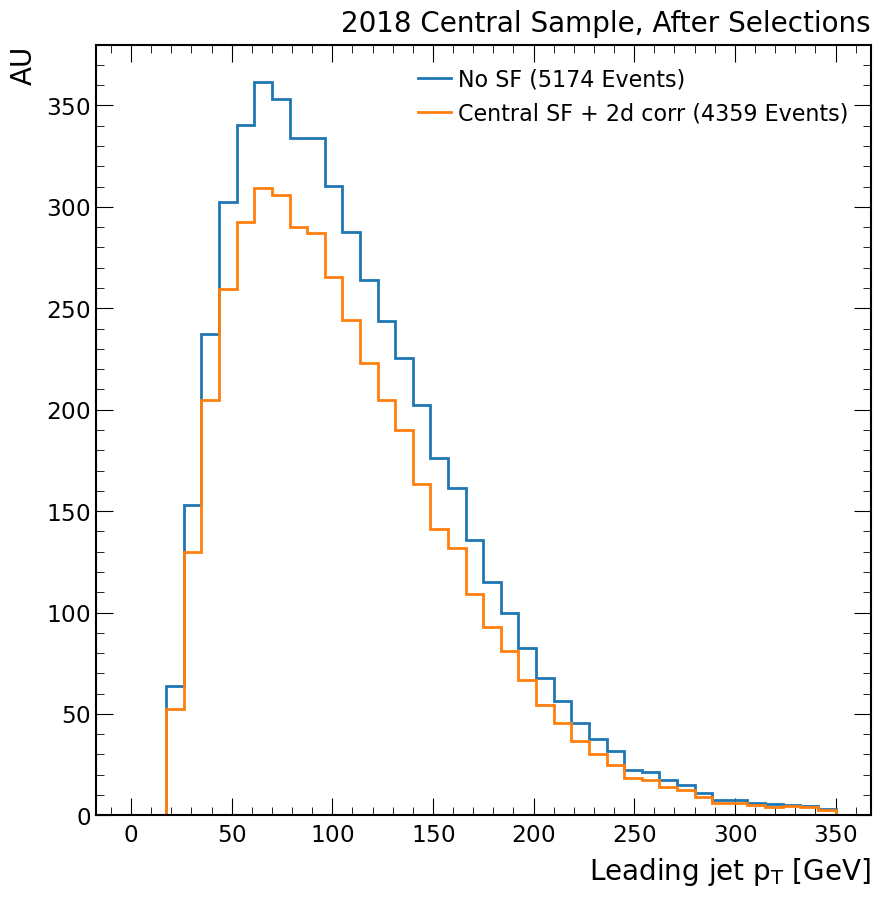

In [105]:
fig, ax = plt.subplots(figsize=(10,10))

n = Hist(tree.jet_pt[:,0], bins=np.linspace(0,350,41), ax=ax, weights=tree.scale)
n = Hist(tree.jet_pt[:,0], bins=np.linspace(0,350,41), ax=ax, weights=tree_central_2d*tree.scale)

handle1 = Line2D([0], [0], color='C0', lw=2, label=f'No SF ({int(len(tree.n_jet) * tree.scale)} Events)')
handle2 = Line2D([0], [0], color='C1', lw=2, label=f'Central SF + 2d corr ({int(ak.sum(tree_central_2d) * tree.scale)} Events)')
ax.legend(handles=[handle1, handle2], loc=0)

ax.set_xlabel(r'Leading jet $p_T$ [GeV]')
ax.set_title('2018 Central Sample, After Selections')
ax.set_ylabel('AU')

fig.savefig('plots/systematics/btag_reshaping_sfs/leading_jet_pt_central.pdf')

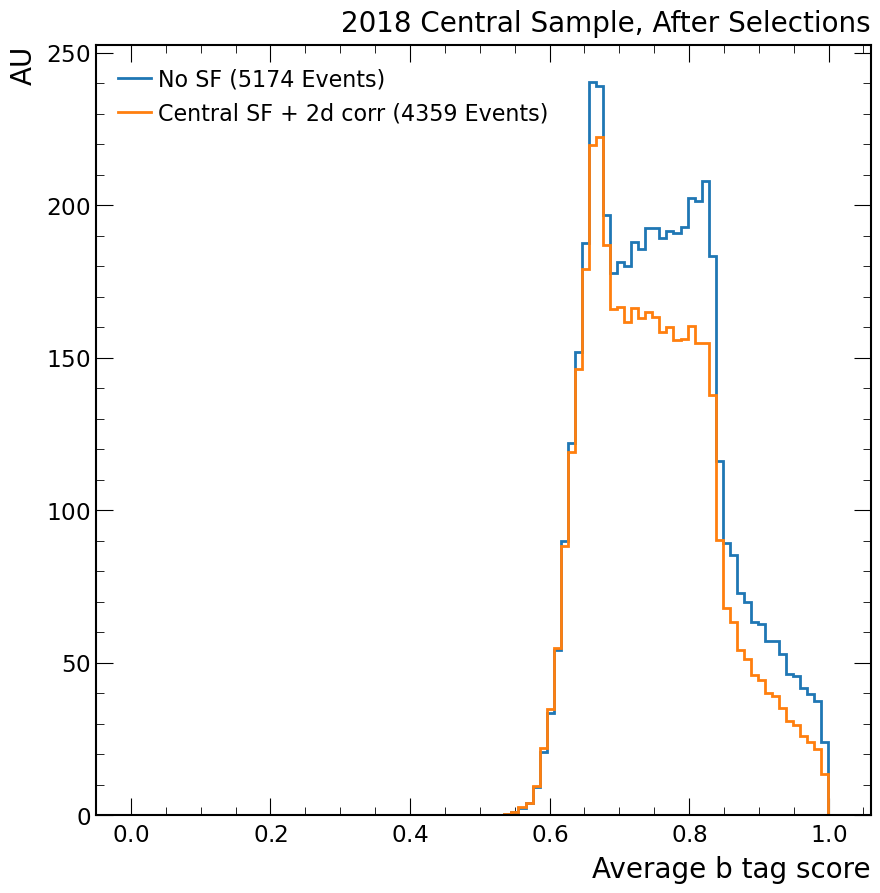

In [109]:
fig, ax = plt.subplots(figsize=(10,10))

n = Hist(tree.btag_avg, bins=np.linspace(0,1.01,101), ax=ax, weights=tree.scale)
# n = Hist(tree.btag_avg, bins=np.linspace(0,1.01,101), ax=ax, weights=tree_central_1d*tree.scale)
n = Hist(tree.btag_avg, bins=np.linspace(0,1.01,101), ax=ax, weights=tree_central_2d*tree.scale)

handle1 = Line2D([0], [0], color='C0', lw=2, label=f'No SF ({int(tree_scale.sum())} Events)')
# handle2 = Line2D([0], [0], color='C1', lw=2, label=f'SF only ({int(ak.sum(tree_central_1d) * tree.scale)} Events)')
handle3 = Line2D([0], [0], color='C1', lw=2, label=f'Central SF + 2d corr ({int(ak.sum(tree_central_2d) * tree.scale)} Events)')
ax.legend(handles=[handle1, handle3], loc=0)

ax.set_xlabel(r'Average b tag score')
ax.set_title('2018 Central Sample, After Selections')
ax.set_ylabel('AU')

fig.savefig('plots/systematics/btag_reshaping_sfs/leading_jet_btagavg_central.pdf')

In [111]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

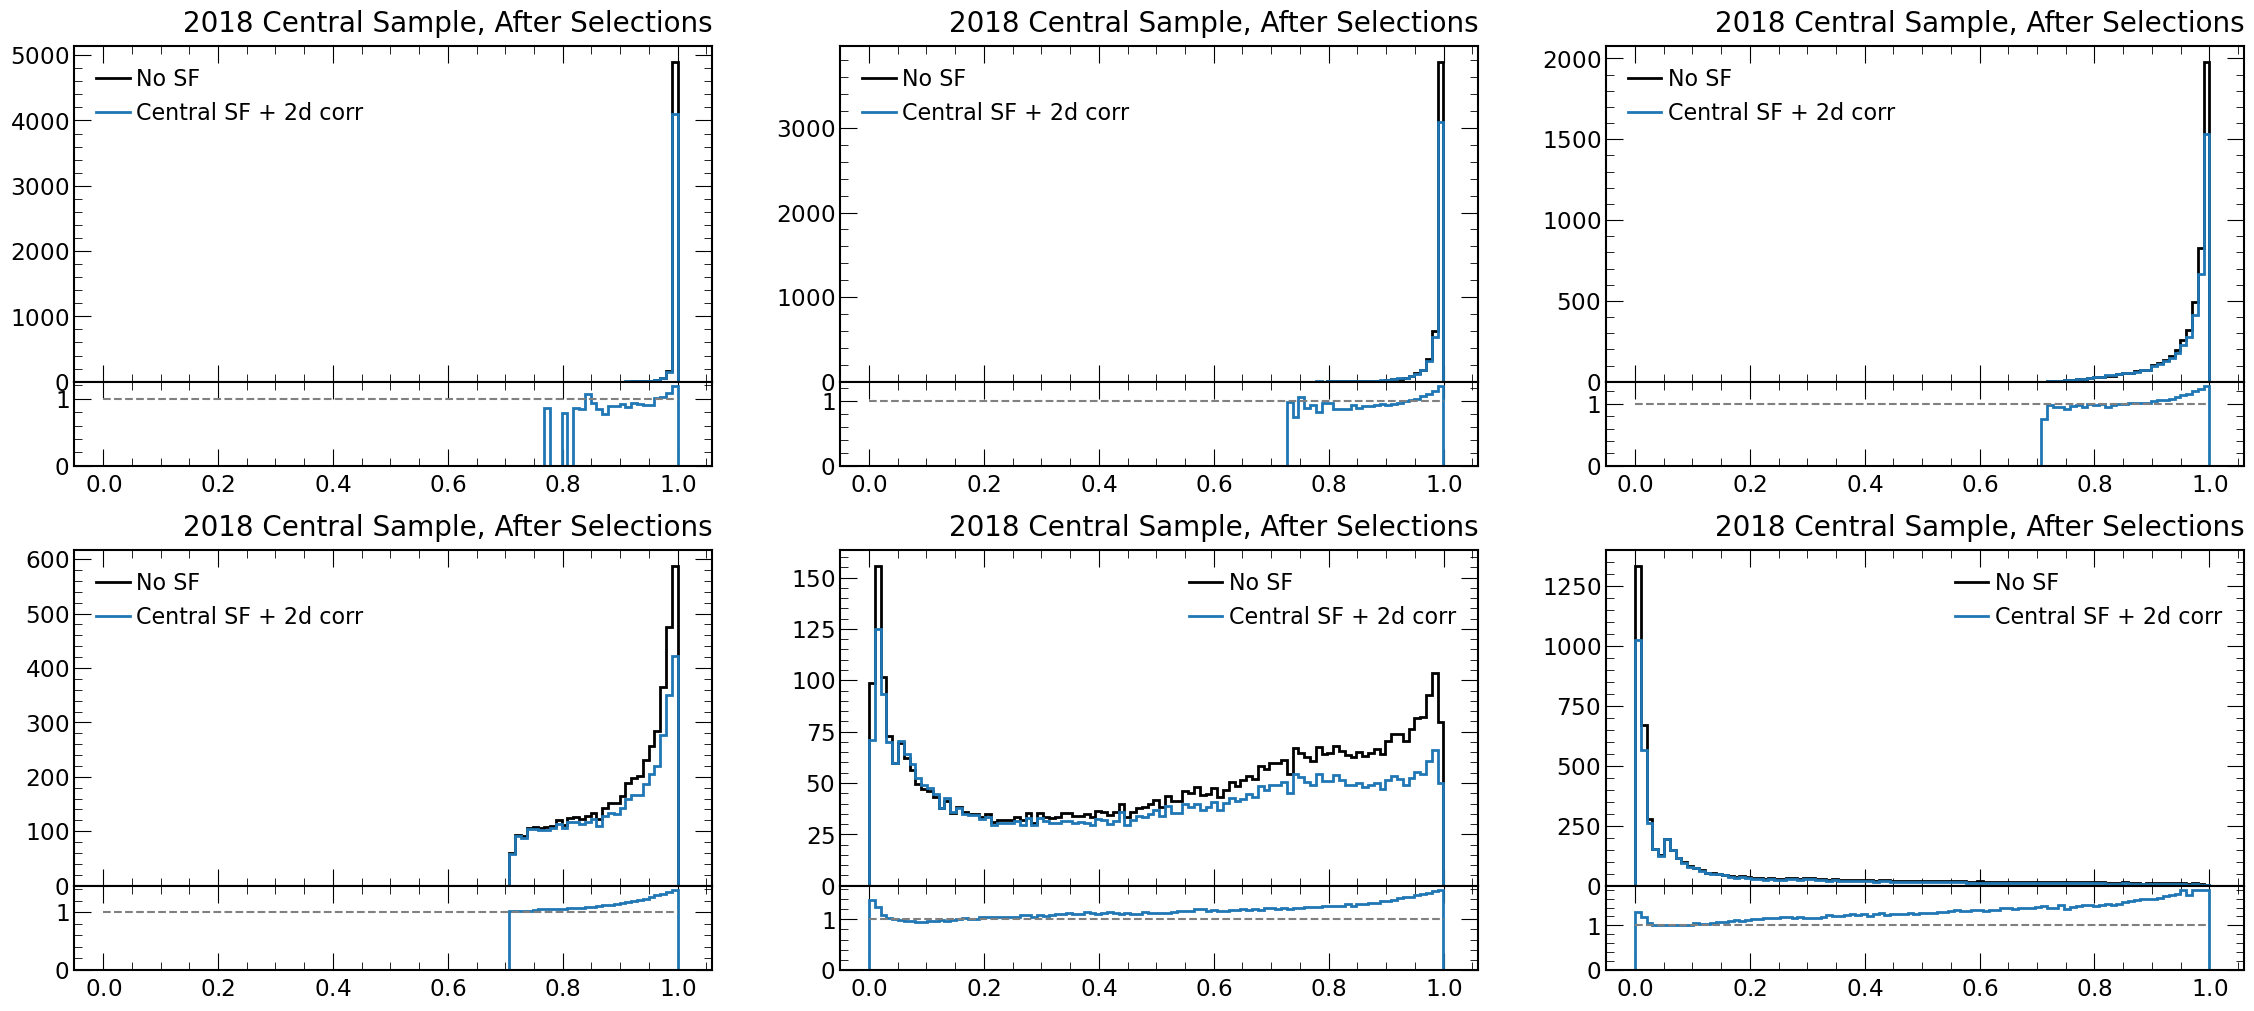

In [113]:
fig = plt.figure(figsize=(28,12))

gs = GridSpec(2, 3, figure=fig)

gs1 = GridSpecFromSubplotSpec(ncols=1, nrows=2, subplot_spec=gs[0], height_ratios=[4,1], hspace=0)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])

n1 = Hist(tree.jet_btag[:,0], bins=b_bins, ax=ax1, weights=tree.scale, color='k')
n2 = Hist(tree.jet_btag[:,0], bins=b_bins, ax=ax1, weights=tree_central_2d*tree.scale, color='C0')

handle1 = Line2D([0], [0], color='k', lw=2, label=f'No SF')
handle2 = Line2D([0], [0], color='C0', lw=2, label=f'Central SF + 2d corr')
ax1.legend(handles=[handle1, handle2])

ax1.set_xlabel('Jet 1 b tag score')
ax1.set_title('2018 Central Sample, After Selections')

ratio = np.nan_to_num(n1 / n2)
n = Hist(x_b, weights=ratio, bins=b_bins, color='C0', ax=ax2)
ax2.plot([0,1], [1,1], '--', color='gray')

gs2 = GridSpecFromSubplotSpec(ncols=1, nrows=2, subplot_spec=gs[1], height_ratios=[4,1], hspace=0)
ax3 = fig.add_subplot(gs2[0])
ax4 = fig.add_subplot(gs2[1])

n1 = Hist(tree.jet_btag[:,1], bins=b_bins, ax=ax3, weights=tree.scale, color='k')
n2 = Hist(tree.jet_btag[:,1], bins=b_bins, ax=ax3, weights=tree_central_2d*tree.scale, color='C0')

handle1 = Line2D([0], [0], color='k', lw=2, label=f'No SF')
handle2 = Line2D([0], [0], color='C0', lw=2, label=f'Central SF + 2d corr')
ax3.legend(handles=[handle1, handle2])

ax3.set_xlabel('Jet 2 b tag score')
ax3.set_title('2018 Central Sample, After Selections')

ratio = n1 / n2
ratio = np.nan_to_num(ratio)
n = Hist(x_b, weights=ratio, bins=b_bins, color='C0', ax=ax4)
ax4.plot([0,1], [1,1], '--', color='gray')

gs3 = GridSpecFromSubplotSpec(ncols=1, nrows=2, subplot_spec=gs[2], height_ratios=[4,1], hspace=0)
ax5 = fig.add_subplot(gs3[0])
ax6 = fig.add_subplot(gs3[1])

n1 = Hist(tree.jet_btag[:,2], bins=b_bins, ax=ax5, weights=tree.scale, color='k')
n2 = Hist(tree.jet_btag[:,2], bins=b_bins, ax=ax5, weights=tree_central_2d*tree.scale, color='C0')

handle1 = Line2D([0], [0], color='k', lw=2, label=f'No SF')
handle2 = Line2D([0], [0], color='C0', lw=2, label=f'Central SF + 2d corr')
ax5.legend(handles=[handle1, handle2])

ax5.set_xlabel('Jet 2 b tag score')
ax5.set_title('2018 Central Sample, After Selections')

ratio = n1 / n2
ratio = np.nan_to_num(ratio)
n = Hist(x_b, weights=ratio, bins=b_bins, color='C0', ax=ax6)
ax6.plot([0,1], [1,1], '--', color='gray')

gs4 = GridSpecFromSubplotSpec(ncols=1, nrows=2, subplot_spec=gs[3], height_ratios=[4,1], hspace=0)
ax7 = fig.add_subplot(gs4[0])
ax8 = fig.add_subplot(gs4[1])

n1 = Hist(tree.jet_btag[:,3], bins=b_bins, ax=ax7, weights=tree.scale, color='k')
n2 = Hist(tree.jet_btag[:,3], bins=b_bins, ax=ax7, weights=tree_central_2d*tree.scale, color='C0')

handle1 = Line2D([0], [0], color='k', lw=2, label=f'No SF')
handle2 = Line2D([0], [0], color='C0', lw=2, label=f'Central SF + 2d corr')
ax7.legend(handles=[handle1, handle2])

ax7.set_xlabel('Jet 2 b tag score')
ax7.set_title('2018 Central Sample, After Selections')

ratio = n1 / n2
ratio = np.nan_to_num(ratio)
n = Hist(x_b, weights=ratio, bins=b_bins, color='C0', ax=ax8)
ax8.plot([0,1], [1,1], '--', color='gray')

gs5 = GridSpecFromSubplotSpec(ncols=1, nrows=2, subplot_spec=gs[4], height_ratios=[4,1], hspace=0)
ax9 = fig.add_subplot(gs5[0])
ax10 = fig.add_subplot(gs5[1])

n1 = Hist(tree.jet_btag[:,4], bins=b_bins, ax=ax9, weights=tree.scale, color='k')
n2 = Hist(tree.jet_btag[:,4], bins=b_bins, ax=ax9, weights=tree_central_2d*tree.scale, color='C0')

handle1 = Line2D([0], [0], color='k', lw=2, label=f'No SF')
handle2 = Line2D([0], [0], color='C0', lw=2, label=f'Central SF + 2d corr')
ax9.legend(handles=[handle1, handle2])

ax9.set_xlabel('Jet 2 b tag score')
ax9.set_title('2018 Central Sample, After Selections')

ratio = n1 / n2
ratio = np.nan_to_num(ratio)
n = Hist(x_b, weights=ratio, bins=b_bins, color='C0', ax=ax10)

ax10.plot([0,1], [1,1], '--', color='gray')

gs6 = GridSpecFromSubplotSpec(ncols=1, nrows=2, subplot_spec=gs[5], height_ratios=[4,1], hspace=0)
ax11 = fig.add_subplot(gs6[0])
ax12 = fig.add_subplot(gs6[1])

n1 = Hist(tree.jet_btag[:,5], bins=b_bins, ax=ax11, weights=tree.scale, color='k')
n2 = Hist(tree.jet_btag[:,5], bins=b_bins, ax=ax11, weights=tree_central_2d*tree.scale, color='C0')

handle1 = Line2D([0], [0], color='k', lw=2, label=f'No SF')
handle2 = Line2D([0], [0], color='C0', lw=2, label=f'Central SF + 2d corr')
ax11.legend(handles=[handle1, handle2])

ax11.set_xlabel('Jet 2 b tag score')
ax11.set_title('2018 Central Sample, After Selections')

ratio = n1 / n2
ratio = np.nan_to_num(ratio)
n = Hist(x_b, weights=ratio, bins=b_bins, color='C0', ax=ax12)

ax12.plot([0,1], [1,1], '--', color='gray')

fig.savefig('plots/systematics/btag_reshaping_sfs/jet_btag_central_ratios.pdf')

array([0.9657307 , 0.54546532, 2.5431786 , ..., 0.72166046, 0.93789623,
       0.9221961 ])

In [114]:
import uproot

In [118]:
with uproot.recreate('test.root') as f:
    f['hist'] = (b4_corrs['bSFshape_central'], n_bins, HT_bins)

In [1]:
import subprocess, shlex

In [2]:
dir_name = '/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag/NMSSM'
cmd = f'ls {dir_name}'

In [22]:
filenames = subprocess.check_output(shlex.split(cmd)).decode('UTF-8').split('\n')[:-1]
filenames = [f'{dir_name}/{f}/ntuple.root\n' for f in filenames if 'NMSSM' in f]

In [23]:
filenames

['/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag/NMSSM/NMSSM_XYH_YToHH_6b_MX_1000_MY_250_2M/ntuple.root\n',
 '/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag/NMSSM/NMSSM_XYH_YToHH_6b_MX_1000_MY_300/ntuple.root\n',
 '/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag/NMSSM/NMSSM_XYH_YToHH_6b_MX_1000_MY_350/ntuple.root\n',
 '/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag/NMSSM/NMSSM_XYH_YToHH_6b_MX_1000_MY_400_2M/ntuple.root\n',
 '/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag/NMSSM/NMSSM_XYH_YToHH_6b_MX_1000_MY_450_2M/ntuple.root\n',
 '/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag/NMSSM/NMSSM_XYH_YToHH_6b_MX_1000_MY_500_2M/ntuple.root\n',
 '/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag/NMSSM/NMSSM_XYH_YToHH_6b_MX_1000_MY_550/ntuple.root\n',
 '/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag/NMSSM/NMSSM_XYH_YToHH_6b_MX_1000_MY_600_3M/ntuple.root\n',
 

In [24]:
with open("sf_files.txt", "w") as f:
    f.writelines(filenames)